## RQ2: How ensemble learning techniques perform in predicting security vulnerbilities?
## Deliverables
1. Confusion matrix for stacking classifier = 1 CM.
2. Performance metrics (Accuracy, Precision and Recall) for stacking classifier = 1 row
3. AUC-ROC curve for stacking classifier x 1 combined graph = 1 AUC-ROC graph.

## Learners
1. Stacking classifier (DT, LR, NB, XGB)

##Datasets
1. Apache Tomcat
2. Apache Struts2-core

### Prerequisites

In [ ]:
# Basic imports
import numpy as np
import pandas as pd
import sys

# Data preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SequentialFeatureSelector as SFS
from sklearn.feature_selection import RFE

# Handling imbalance data
from imblearn.over_sampling  import RandomOverSampler
from imblearn.under_sampling  import RandomUnderSampler

# CV
from sklearn.model_selection import RepeatedStratifiedKFold

# Performance metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
from numpy import mean, std
from sklearn.metrics import ConfusionMatrixDisplay as CMD
from sklearn.metrics import roc_curve

#ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb

# Ensemble techniques
from sklearn.ensemble import StackingClassifier

def preprocess(dataset_idx, target):
    ds = ["./datasets/tomcat-final.csv", "./datasets/struts-final.csv"]
    df = pd.read_csv(ds[dataset_idx])
    np.set_printoptions(threshold=np.inf)
    pd.set_option('max_columns', None)
    print(f"Dataframe {ds[dataset_idx][-16:]} created..\nTotal number of rows: ", df.shape[0])
    return split_features_variables(df, target)

def split_features_variables(df, target):
    y_cols = ['vulnerable', 'severity', 'title']
    feature_columns = df.columns[2:-4]
    label_mapping = []
    train, test = train_test_split(df, shuffle=True,test_size=0.2)
    X = train[feature_columns]
    test_X = test[feature_columns]
    if y_cols[target] == 'vulnerable':
        return X, test_X, train[y_cols[target]], test[y_cols[target]]      
    else: 
        label_X_train, label_X_test, label_mapping= label_encode(train, test, y_cols[target])
        return X, test_X, label_X_train[y_cols[target]], label_X_test[y_cols[target]], label_mapping

def label_encode(train, test, target):
    print('Labelled target found..')
    train_target = train.copy()
    test_target = test.copy()
    df = train.append(test, ignore_index=True)
    le = LabelEncoder()
    le.fit(df[target])
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    train_target[target] = le.transform(train[target])
    test_target[target] = le.transform(test[target])
    print('Encoded...')
    return train_target, test_target, le_name_mapping

def fit_feature_set(feature_set):
    global X_ros
    X_ros = X_ros[feature_set]
    global test_X
    test_X = test_X[feature_set]

def stacking():
    level0 = list()
    level0.append(('lr', LogisticRegression(solver='liblinear',class_weight='balanced', max_iter=500)))
    level0.append(('dt', DecisionTreeClassifier(ccp_alpha=0.036)))
    level0.append(('nb', GaussianNB()))
    level1 = xgb.XGBClassifier(n_estimators=500)
    model = StackingClassifier(estimators=level0, final_estimator=level1, stack_method='predict')
    return model

def predict(model):
    model.fit(X_ros, y_ros)
    predictions = model.predict(test_X)
    pred_proba = model.predict_proba(test_X)
    accuracy = accuracy_score(test_Y, predictions)
    average = ''
    if target != 0:
      average = 'micro'
    else:
      average = 'binary'
    precision = precision_score(test_Y, predictions, average=average)
    recall = recall_score(test_Y, predictions,average=average)
    return [accuracy, precision, recall, pred_proba ,predictions]

### Experiments

In [ ]:
ds = 1
target = 2
datasets = ['Tomcat', 'Struts']
targets = ['Vulnerable','Severity', 'Title']
label_mappings = []
if target == 0:
  X, test_X, y, test_Y = preprocess(ds, target)
else:
  X, test_X, y, test_Y, label_mappings = preprocess(ds, target)
ros = RandomUnderSampler(sampling_strategy='majority')
X_ros, y_ros = ros.fit_resample(X, y)
print(f'Total length after sampling: {len(y_ros)}')
if len(label_mappings) > 0:
  labels = label_mappings.keys()
  values = label_mappings.values()
  print(pd.DataFrame([labels, values]).T)

Dataframe struts-final.csv created..
Total number of rows:  19372
Labelled target found..
Encoded...
Total length after sampling: 36
                                                 0  1
0                                                0  0
1                        Access Restriction Bypass  1
2                Cross-site Request Forgery (CSRF)  2
3                          Denial of Service (DoS)  3
4                     Improper Action Name Cleanup  4
5     Regular Expression Denial of Service (ReDoS)  5
6                            Remote Code Execution  6
7                      Remote Code Execution (RCE)  7
8  Unrestricted Upload of File with Dangerous Type  8


### Machine Learning

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,



-----Model: Stacking Classifier-----
Accuracy: 0.0647741935483871
Precision: 0.0647741935483871
Recall: 0.0647741935483871


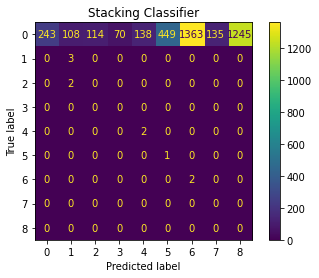

In [ ]:
# Recursive feature eliminator
rfe = RFE(estimator=DecisionTreeClassifier())
rfe.fit(X_ros, y_ros)
rfe_features = []
for i in range(X.shape[1]):
    if(rfe.support_[i] == 1):
        rfe_features.append(X.columns[i])
fit_feature_set(rfe_features)

# Stacking Classifier
model = stacking()
pred_model = predict(model)
acc, pre, rec ,stk_pred = pred_model[0], pred_model[1], pred_model[2], pred_model[-2]
print('\n-----Model: Stacking Classifier-----')
print(f'Accuracy: {mean(acc)}')
print(f'Precision: {mean(pre)}')
print(f'Recall: {mean(rec)}')
stk_fig = CMD.from_predictions(test_Y,pred_model[-1])
stk_fig.ax_.set_title('Stacking Classifier')
print(stk_fig)

### AUC-ROC curve

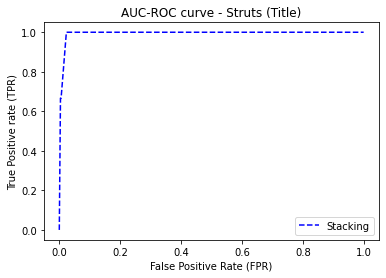

In [ ]:
# roc curve for models
fpr = {}
tpr = {}
thresh ={}
    
fpr1, tpr1, thresh1 = roc_curve(test_Y, stk_pred[:,1], pos_label=1)
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_Y))]
p_fpr, p_tpr, _ = roc_curve(test_Y, random_probs, pos_label=1)

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--', color='blue', label='Stacking')

# title
plt.title('AUC-ROC curve - '+datasets[ds].capitalize()+' ('+targets[target].capitalize()+')')
# x label
plt.xlabel('False Positive Rate (FPR)')
# y label
plt.ylabel('True Positive rate (TPR)')

plt.legend(loc='best')
plt.show();